<a href="https://colab.research.google.com/github/ColeHenson/Data-Science24-25/blob/main/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [3]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}
# model_T is a famously a type of car
#bascially I just copied the code from the answer key and then changed all the
#normal functions to t or half student t and set nu=1 cause why not? and maybe
# I want weak priors.
with pm.Model(coords=aa_coords) as cs_nh_model_T:
    #priors
    #dims="aa" means to apply the prior seperately to each amino acid
    μ = pm.StudentT('μ', mu=0, sigma = 10, nu=1,
                  dims="aa")
    nu = pm.HalfStudentT('nu', sigma = 10, nu=1,
                      dims="aa")
    #The idx variable tells my model which diffs belong to the same amino acid
    #this will cause my model to generate a posterior for each amino acid
    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  nu = nu[aa_idx],
                  observed=cs_data.diff_TminusE)

    #cs for chemshift, nh for nonheirarchical
    idata_cs_nh_T = pm.sample()



Output()

Output()

Output()

Output()

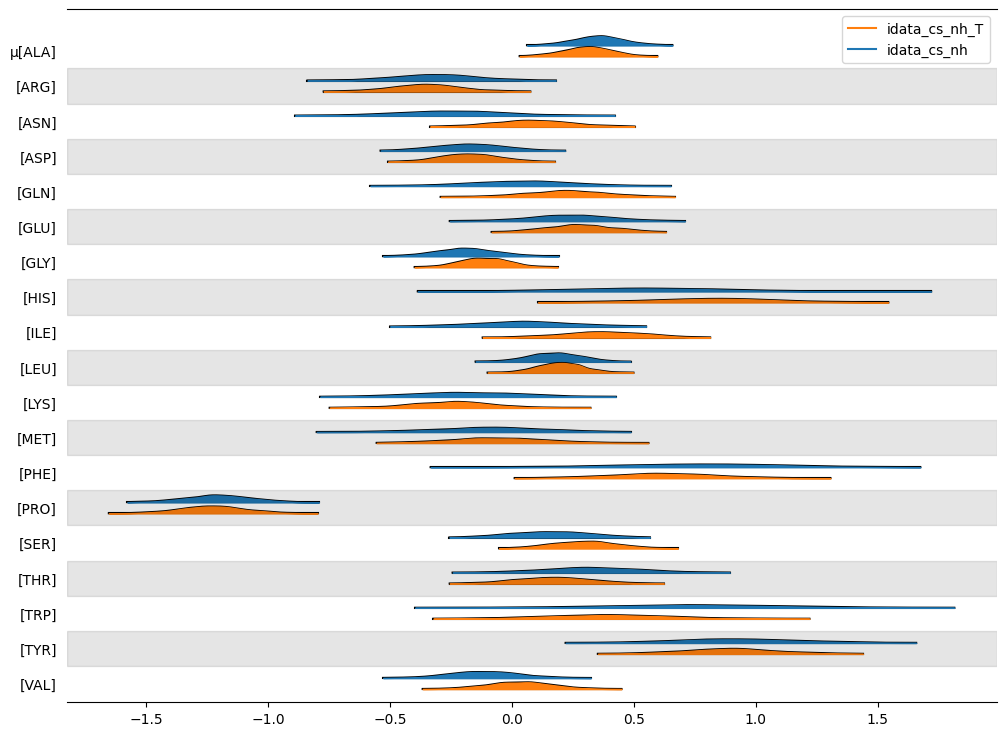

In [4]:
with pm.Model(coords=aa_coords) as cs_nh_model:
    #priors
    #dims="aa" means to apply the prior seperately to each amino acid
    μ = pm.Normal('μ', mu=0, sigma=10,
                  dims="aa")
    σ = pm.HalfNormal('σ', sigma=10,
                      dims="aa")

    #The idx variable tells my model which diffs belong to the same amino acid
    #this will cause my model to generate a posterior for each amino acid
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed=cs_data.diff_TminusE)

    #cs for chemshift, nh for nonheirarchical
    idata_cs_nh = pm.sample()
    axes = az.plot_forest([idata_cs_nh,idata_cs_nh_T], kind="ridgeplot",
                      model_names=['idata_cs_nh', 'idata_cs_nh_T'], var_names = 'μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

<Axes: xlabel='y'>

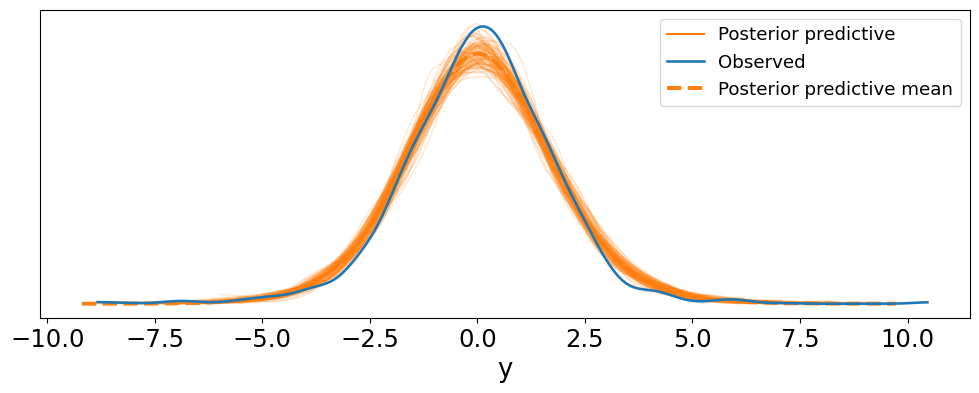

In [5]:
pm.sample_posterior_predictive(idata_cs_nh, model=cs_nh_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_nh, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Output()

(-10.0, 10.0)

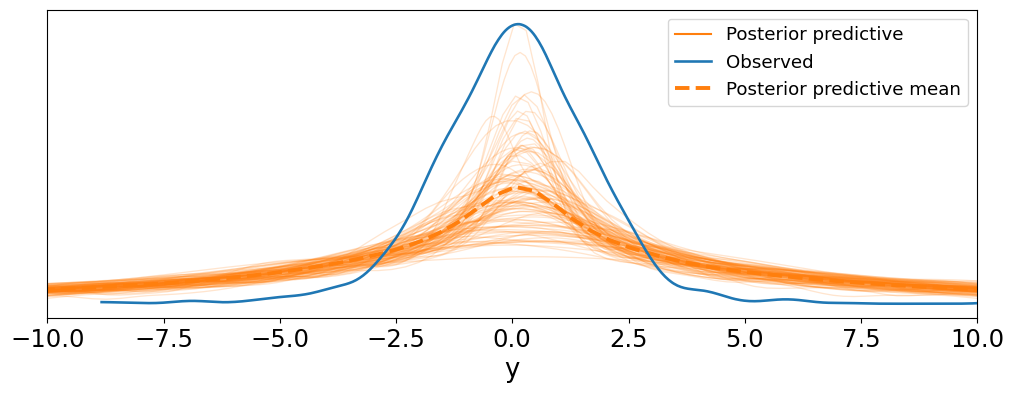

In [6]:
pm.sample_posterior_predictive(idata_cs_nh_T, model=cs_nh_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_cs_nh_T, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(-10, 10)

The normal distribution fits the data far better than my student t distribution.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [7]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [8]:
with pm.Model(coords = sccr_coords) as sccr_model_original:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_original = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [9]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # remove hyper parameters copy everyhting else
    #
    # μ = pm.Beta('μ', alpha = 2, beta = 20)
    # ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ = pm.Beta('μ', alpha = 2, beta = 20, dims = "pos")

    ν = pm.Gamma('ν', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ[pos_idx], nu = ν[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

(<xarray.Dataset> Size: 43kB
 Dimensions:  (θ_dim_0: 2682, pos: 4)
 Coordinates:
   * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
   * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
 Data variables:
     θ        (θ_dim_0) float64 21kB 1.0 1.003 1.002 1.002 ... 1.001 1.0 1.002
     μ        (pos) float64 32B 1.002 1.0 1.039 1.0
     ν        (pos) float64 32B 1.021 1.003 1.039 1.005,
 array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
        [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
        [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>]],
       dtype=object))

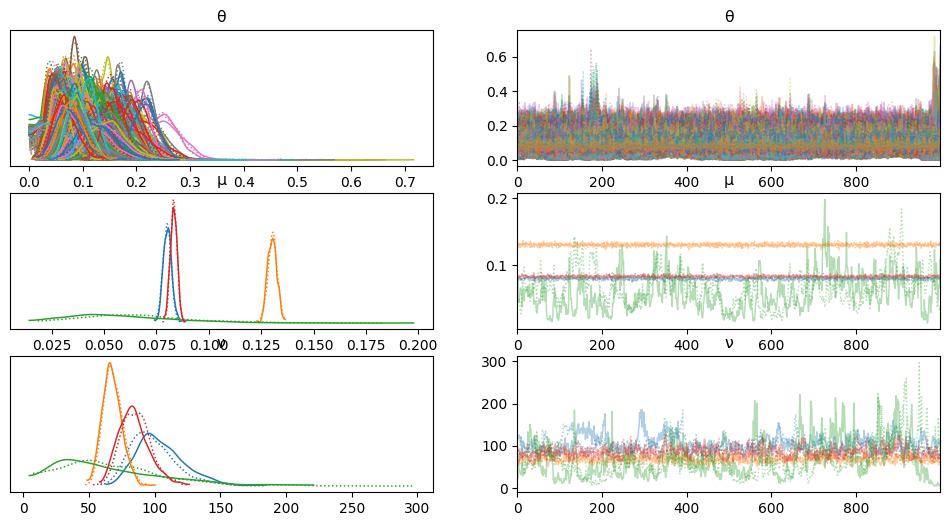

In [10]:
az.rhat(idata_sccr), az.plot_trace(idata_sccr)


(<xarray.Dataset> Size: 43kB
 Dimensions:  (θ_dim_0: 2682, pos: 4)
 Coordinates:
   * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
   * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
 Data variables:
     θ        (θ_dim_0) float64 21kB 0.9996 1.003 1.001 ... 0.9999 1.005 1.001
     μ        float64 8B 1.004
     μ_p      (pos) float64 32B 1.001 1.001 1.019 1.001
     ν        float64 8B 1.004
     ν_p      (pos) float64 32B 1.012 1.001 1.498 1.007,
 array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
        [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
        [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
        [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
        [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
       dtype=object))

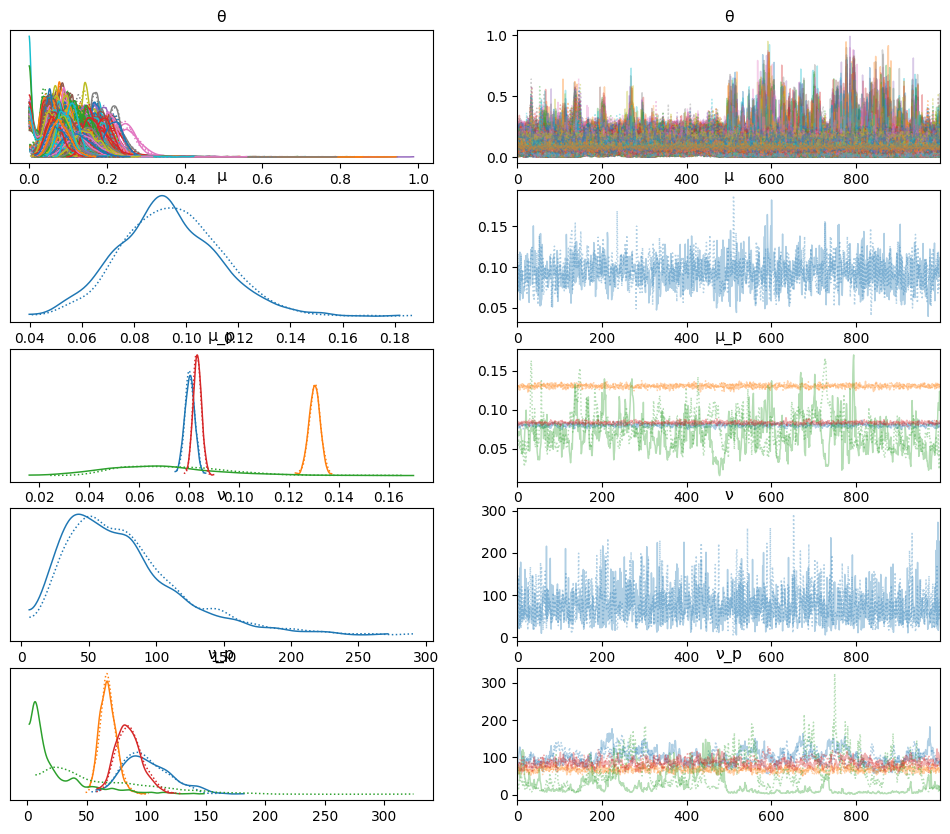

In [11]:
az.rhat(idata_sccr_original), az.plot_trace(idata_sccr_original)


**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

Text(0.5, 1.0, 'Goalkeeper position mean')

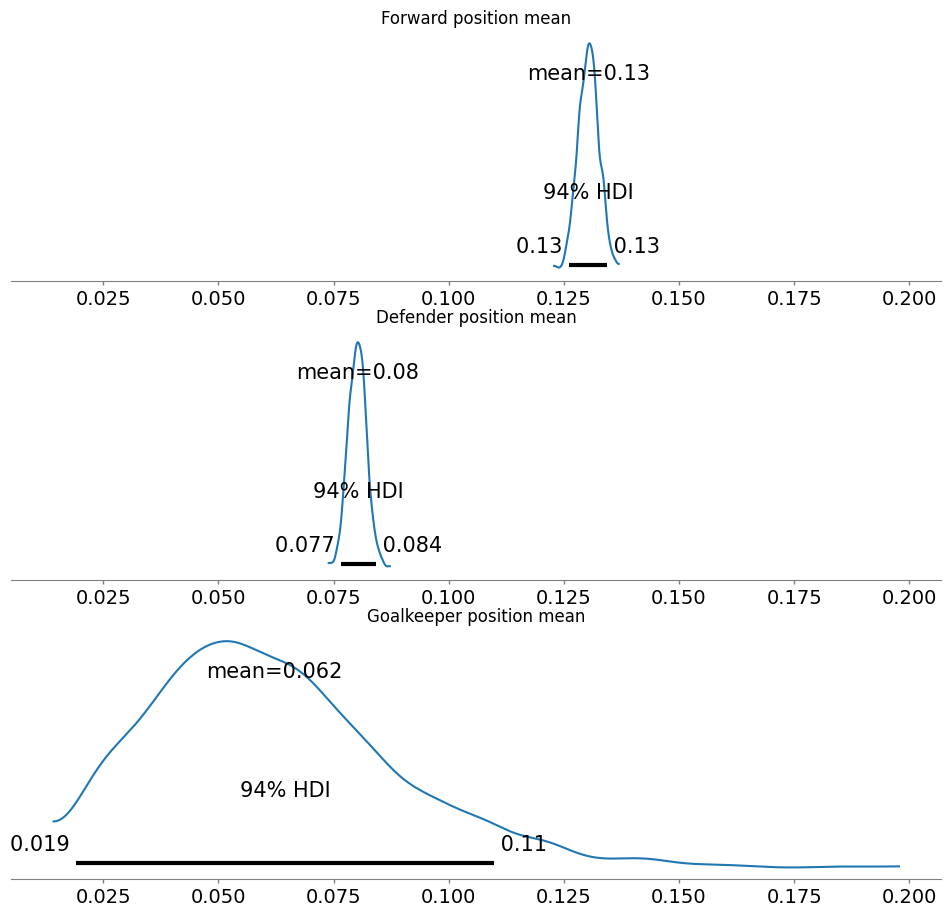

In [15]:
_, ax = plt.subplots(3, 1, figsize=(12, 11), sharex=True)

az.plot_posterior(idata_sccr.posterior.sel(pos="FW"), var_names='μ', ax=ax[0])
ax[0].set_title(r"Forward position mean")

az.plot_posterior(idata_sccr.posterior.sel(pos="DF"), var_names='μ', ax=ax[1])
ax[1].set_title(r"Defender position mean")

az.plot_posterior(idata_sccr.posterior.sel(pos="GK"), var_names='μ', ax=ax[2])
ax[2].set_title(r"Goalkeeper position mean")



**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [48]:
sccr_data = pd.read_csv(url_sccr)

# remove goal keepers
sccr_data_h = sccr_data.query('position != "GK"')
sccr_data_h['position'] = sccr_data_h['position'].astype('category')

pos_idx = sccr_data_h.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data_h.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}



<ipython-input-48-e95c8e91f148>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sccr_data_h['position'] = sccr_data_h['position'].astype('category')


In [49]:
with pm.Model(coords = sccr_coords) as sccr_model_h:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_h.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_h.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_h = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

The model without the goalkeepers processed far faster partially because there are less data points but also because the model struggles to handle the weird goalkeeper values.

When I don't include the GKs in the data set I lose the potential relationship between the scoring abilities of goalkeeper and players of other positions as well as the obvios values for the goalscoring of goalkeepers themselves.

(<xarray.Dataset> Size: 40kB
 Dimensions:  (θ_dim_0: 2517, pos: 3)
 Coordinates:
   * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
   * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
 Data variables:
     θ        (θ_dim_0) float64 20kB 1.0 1.002 1.004 1.002 ... 1.003 1.0 1.003
     μ        float64 8B 1.002
     μ_p      (pos) float64 24B 1.003 1.001 1.008
     ν        float64 8B 1.002
     ν_p      (pos) float64 24B 1.018 1.001 1.042,
 array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
        [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
        [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
        [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
        [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
       dtype=object))

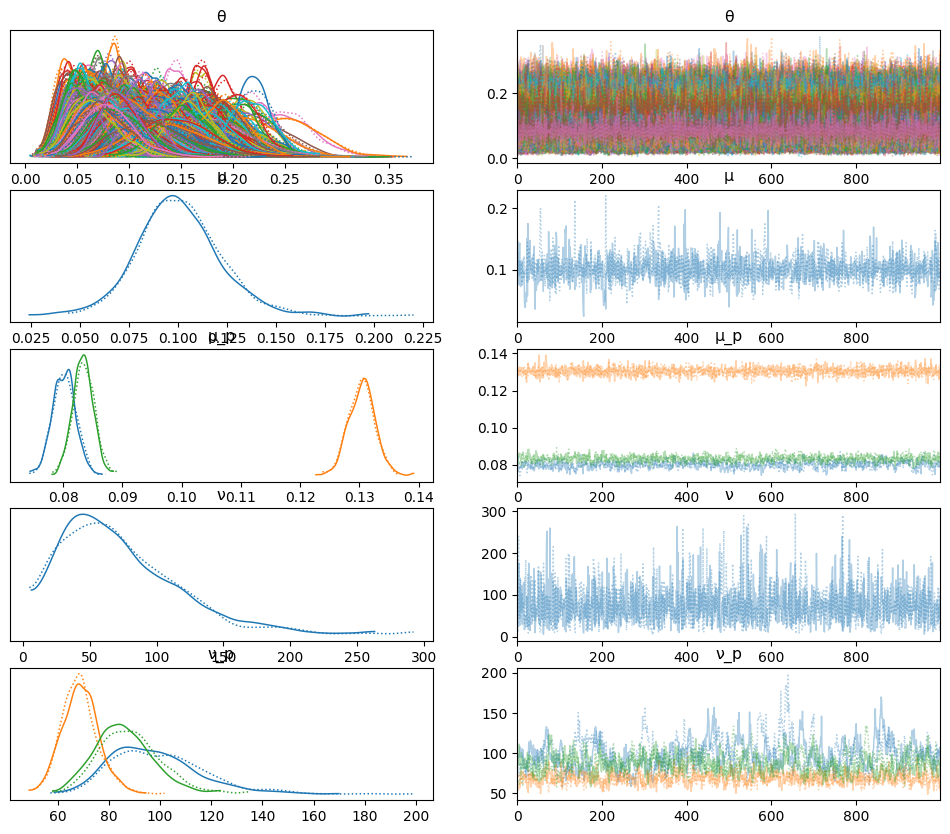

In [52]:
# plot trace
az.rhat(idata_sccr_h), az.plot_trace(idata_sccr_h)